In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import glob

import os
from matplotlib import colors
from matplotlib import pyplot as plt
import numpy as np
import xarray as xr

In [3]:
# Set up path to history output

### pick a case
# case = "mom.updated_fesedflux"
case = "mom_oob.003"
# case = "mom_hybrid_z.003"

### output in rundir or archive?
# hist_dir = os.path.join(os.sep, "glade", "scratch", "mlevy", case, "run")
# hist_dir = os.path.join(os.sep, "glade", "scratch", "mlevy", case, "run", "v_ext")
hist_dir = os.path.join(os.sep, "glade", "scratch", "mlevy", "archive", case, "ocn", "hist")

### read hist_file
hist_file = os.path.join(hist_dir, f"{case}.mom6.h_bgc_monthly_z_0001_01.nc")
# hist_file = os.path.join(hist_dir, "mom.updated_fesedflux.mom6.hm_bgc_monthly_z_0001_01.nc")

# Read FESEDFLUX field from file
output_ds = xr.open_dataset(hist_file, decode_times=False).isel(time=0)
for z_coord in ["z_pop_l", "zl", "z_l"]:
    if z_coord in output_ds.dims:
        break

if z_coord not in output_ds.dims:
    raise KeyError(f"Can not find vertical dim in {list(output_ds.dims.keys())}")

print(f"Depth coordinate is {z_coord}")

Depth coordinate is z_pop_l


In [4]:
# Set up paths for the Fe sediment flux and Fe vent flux forcing files
forcing_datestamp = "211020"
forcing_dir = os.path.join(os.sep, "glade", "work", "mlevy", "cesm_inputdata")
fesedflux_file = os.path.join(forcing_dir, f"fesedflux_total_reduce_oxic_tx0.66v1.c{forcing_datestamp}.nc")
feventflux_file = os.path.join(forcing_dir, f"feventflux_5gmol_tx0.66v1.c{forcing_datestamp}.nc")

# Read in both files, rename dimensions to match MOM output
ds1 = xr.open_dataset(fesedflux_file).rename({'DEPTH': z_coord, 'NLAT': 'yh', 'NLON': 'xh'})
ds2 = xr.open_dataset(feventflux_file).rename({'DEPTH': z_coord, 'NLAT': 'yh', 'NLON': 'xh'})

# Forcing dataset is the sum of the `FESEDFLUXIN` fields from both files
forcing_da = ds1.FESEDFLUXIN + ds2.FESEDFLUXIN
forcing_da.attrs = ds1.FESEDFLUXIN.attrs
# forcing_da.isel(z_pop_l=0).plot()

In [5]:
# Make sure vertical coordinate matches the coordinate in forcing_da (otherwise differencing won't work)
if z_coord == "z_pop_l":
    output_da = output_ds.FESEDFLUX.assign_coords({z_coord: forcing_da[z_coord]})
else:
    output_da = output_ds.FESEDFLUX

# Unit conversion to match forcing file: 1 nmol/cm^2 = 10 micromol/m^2, 1 -/s = 86400 -/d
if output_da.attrs["units"] == "nmol/cm^2/s":
    output_da.data = output_da.data * 864000
    output_da.attrs["units"] = "micromol/m^2/d"
# output_da.isel(z_pop_l=0).plot()

In [6]:
def count_missing(da):
    return np.sum(np.isnan(da.data))

if z_coord == "z_pop_l":
    print(f"history file has {count_missing(output_da)} missing values")
    print(f"forcing file has {count_missing(forcing_da)} missing values")

history file has 7496875 missing values
forcing file has 5739360 missing values


In [7]:
# Print some quick statistics
def print_min_max(da):
    print(f"Min: {da.min().data}, Max: {da.max().data}")

def plot_single_level(da_in, level=0, **plot_kwargs):
#     plot_kwargs['cmap'] = plot_kwargs.get('cmap', 'bwr')
    da = da_in.isel({z_coord: level})
    print_min_max(da)
    fig = plt.figure(figsize=[12,7])
    ax = fig.add_subplot(1, 1, 1)
    ax.set_facecolor('0.7')
    da.plot(ax=ax, **plot_kwargs)

def plot_vertical_sum(da_in, mask, **plot_kwargs):
    da = da_in.sum(z_coord).where(np.logical_not(mask))
    print_min_max(da)
    fig = plt.figure(figsize=[12,7])
    ax = fig.add_subplot(1, 1, 1)
    ax.set_facecolor('0.7')
    da.plot(ax=ax, **plot_kwargs)

In [8]:
if z_coord == "z_pop_l":
    print("Sum:")
    print_min_max((output_da - forcing_da).sum(z_coord))
#     for k in range(60):
#         print(f"Level {k+1}:")
#         print_min_max((output_da - forcing_da).isel({z_coord:k}))
print("Sum:")
print_min_max(output_da.sum(z_coord) - forcing_da.sum(z_coord))

Sum:
Min: 0.0, Max: 21.36312910076306
Sum:
Min: -2.648137265026662e-11, Max: 2.0961010704922955e-13


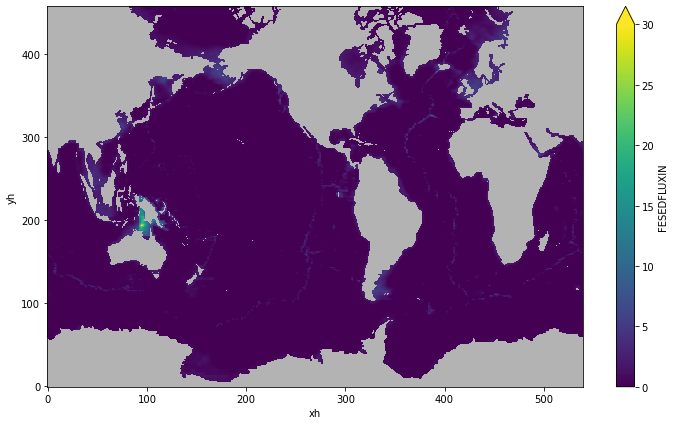

In [9]:
# Set land mask so we can use dark gray for continents
land_mask = np.logical_or(np.isnan(output_da.isel({z_coord: 0}).data), np.isnan(forcing_da.isel({z_coord: 0}).data))

# Vertical sum of forcing data
fig = plt.figure(figsize=[12,7])
ax = fig.add_subplot(1, 1, 1)
ax.set_facecolor('0.7')
forcing_da.sum(z_coord).where(np.logical_not(land_mask)).plot(ax=ax, vmin=0, vmax=30);

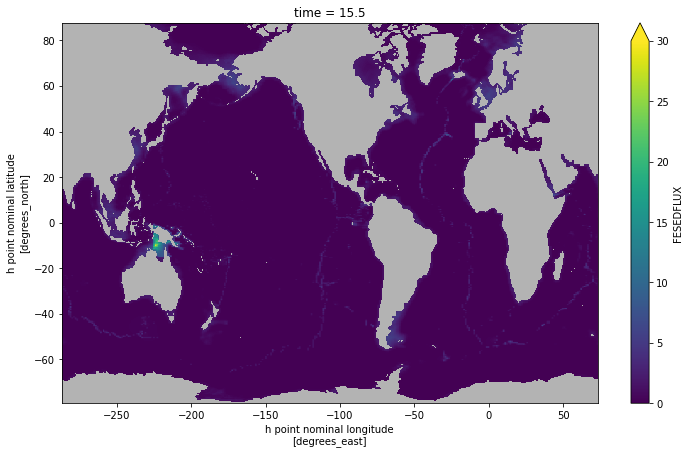

In [10]:
# Vertical sum of hsitory file data
fig = plt.figure(figsize=[12,7])
ax = fig.add_subplot(1, 1, 1)
ax.set_facecolor('0.7')
output_da.sum(z_coord).where(np.logical_not(land_mask)).plot(ax=ax, vmin=0, vmax=30);

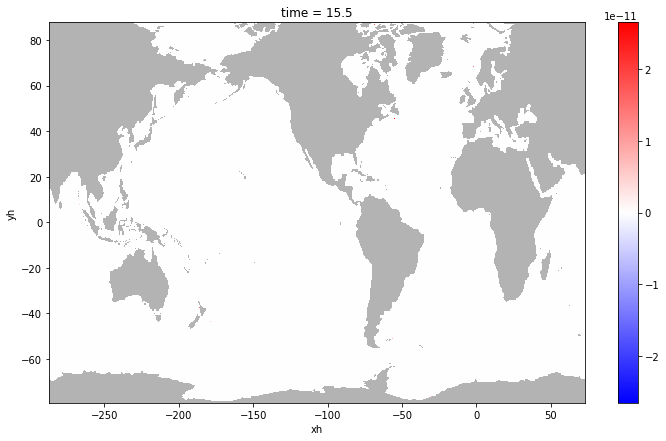

In [11]:
# Vertical sum of forcing data - vertical sum of history data
fig = plt.figure(figsize=[12,7])
ax = fig.add_subplot(1, 1, 1)
ax.set_facecolor('0.7')
(forcing_da.sum(z_coord) - output_da.sum(z_coord)).where(np.logical_not(land_mask)).plot(ax=ax, cmap='bwr');

Min: 0.0, Max: 30.517087627583052
Min: 0.0, Max: 30.517087627583123
Min: -3.9850256372618453, Max: 21.341030708315767


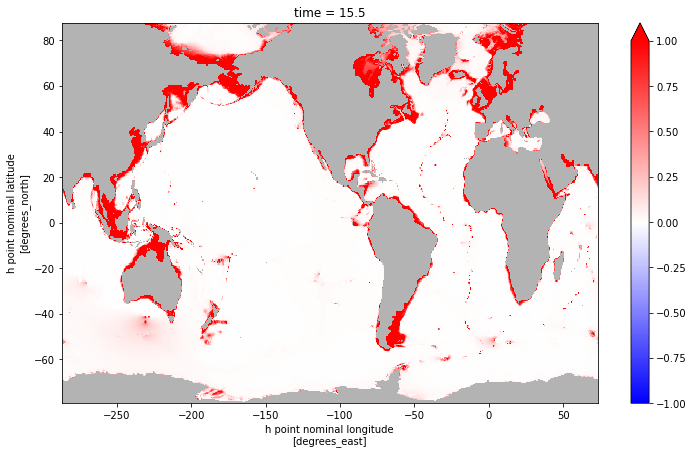

In [12]:
print_min_max(output_da.sum(z_coord))
print_min_max(forcing_da.sum(z_coord))

if z_coord == "z_pop_l":
    # Difference is model - forcing, so positive values => model > forcing
    diff_da = output_da - forcing_da

    # Difference is model - forcing, so positive values => model > forcing
    diff_da_vert_sum = diff_da.sum(z_coord).where(np.logical_not(land_mask))

    # Print some stats and then plot
    print_min_max(diff_da)

    fig = plt.figure(figsize=[12,7])
    ax = fig.add_subplot(1, 1, 1)
    ax.set_facecolor('0.7')
    diff_da_vert_sum.plot(ax=ax, vmin=-1, vmax=1, cmap='bwr');

Min: -0.003695191381760665, Max: 16.66038301444278


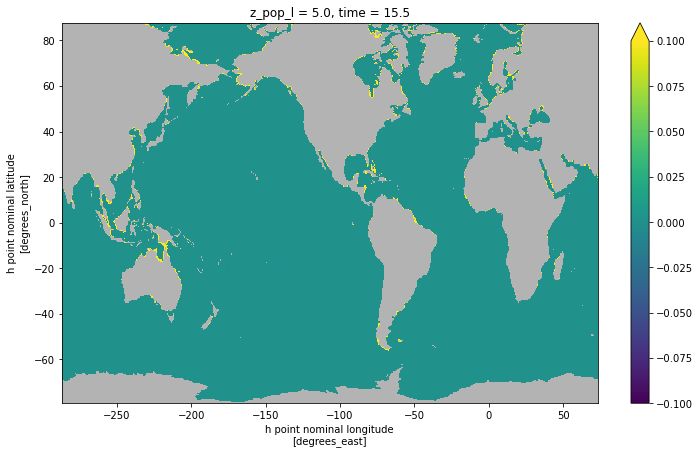

In [13]:
if z_coord == "z_pop_l":
    plot_single_level(diff_da, level=0, vmin=-0.1, vmax=0.1)

Min: -0.9821893891343043, Max: 15.931528140520493


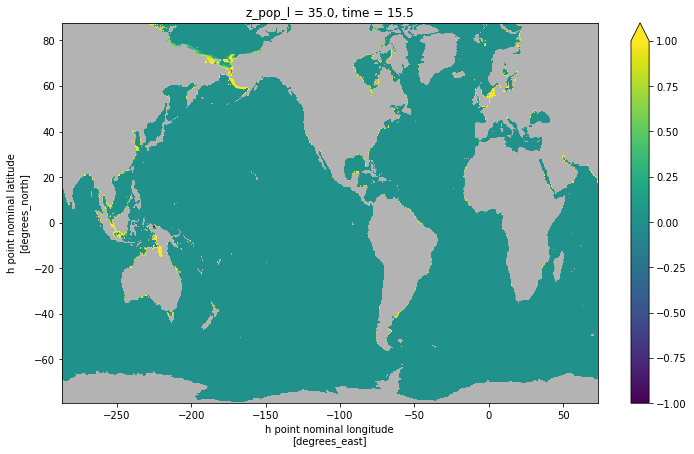

In [14]:
if z_coord == "z_pop_l":
    plot_single_level(diff_da, level=3, vmin=-1, vmax=1)

#### Looking at some fields from year 20?

In [22]:
mom_case = "mom_oob.003"
# mom_case = "mom_hybrid_z.003"
pop_case = "pop_no_mcog"

mom_hist_dir = os.path.join(os.sep, "glade", "scratch", "mlevy", "archive", mom_case, "ocn", "hist")
pop_hist_dir = os.path.join(os.sep, "glade", "scratch", "mlevy", "archive", pop_case, "ocn", "hist")

mom_static_ds = xr.open_dataset(os.path.join(mom_hist_dir, f"{mom_case}.mom6.static.nc"))
mom_hist_files = glob.glob(os.path.join(mom_hist_dir, f"{mom_case}.mom6.h_bgc_monthly_z_0020_*.nc"))
# hist_file = os.path.join(hist_dir, "mom.updated_fesedflux.mom6.hm_bgc_monthly_z_0001_01.nc")
pop_hist_files = glob.glob(os.path.join(pop_hist_dir, f"{pop_case}.pop.h.0020-*.nc"))

mom_hist_files.sort()
pop_hist_files.sort()

mom_hist_ds = xr.open_mfdataset(mom_hist_files, decode_times=False, parallel=False, coords="minimal", join="override")
pop_hist_ds = xr.open_mfdataset(pop_hist_files, decode_times=False, parallel=False, coords="minimal", join="override")

<xarray.Dataset>
Dimensions:      (xh: 540, yh: 458, time: 1, xq: 540, yq: 458)
Coordinates:
  * xh           (xh) float64 -286.7 -286.0 -285.3 -284.7 ... 71.33 72.0 72.67
  * yh           (yh) float64 -79.2 -79.08 -78.95 -78.82 ... 87.64 87.71 87.74
  * time         (time) object 0001-01-01 00:00:00
  * xq           (xq) float64 -286.3 -285.7 -285.0 -284.3 ... 71.67 72.33 73.0
  * yq           (yq) float64 -79.14 -79.01 -78.89 -78.76 ... 87.68 87.73 87.74
Data variables: (12/15)
    geolon       (yh, xh) float64 ...
    geolat       (yh, xh) float64 ...
    geolon_c     (yq, xq) float64 ...
    geolat_c     (yq, xq) float64 ...
    geolon_u     (yh, xq) float64 ...
    geolat_u     (yh, xq) float64 ...
    ...           ...
    depth_ocean  (yh, xh) float64 ...
    wet          (yh, xh) float64 ...
    wet_c        (yq, xq) float64 ...
    wet_u        (yh, xq) float64 ...
    wet_v        (yq, xh) float64 ...
    Coriolis     (yq, xq) float64 ...
Attributes:
    filename:   mom_oob.003.mom6.static.nc
    title:      MOM6 diagnostic fields table for CESM case: mom_oob.003
    grid_type:  regular
    grid_tile:  N/A

In [23]:
pop_hist_ds

<xarray.Dataset>
Dimensions:                          (time: 12, d2: 2, moc_comp: 3, transport_comp: 5, transport_reg: 2, z_t: 60, z_t_150m: 15, z_w: 60, z_w_top: 60, z_w_bot: 60, lat_aux_grid: 395, moc_z: 61, nlat: 384, nlon: 320)
Coordinates: (12/14)
    transport_components             (transport_comp) |S384 dask.array<chunksize=(5,), meta=np.ndarray>
    transport_regions                (transport_reg) |S384 dask.array<chunksize=(2,), meta=np.ndarray>
  * time                             (time) float64 7.331e+03 ... 7.665e+03
  * z_t                              (z_t) float32 500.0 1.5e+03 ... 5.375e+05
  * z_t_150m                         (z_t_150m) float32 500.0 ... 1.45e+04
  * z_w                              (z_w) float32 0.0 1e+03 ... 5e+05 5.25e+05
    ...                               ...
  * lat_aux_grid                     (lat_aux_grid) float32 -79.49 ... 90.0
  * moc_z                            (moc_z) float32 0.0 1e+03 ... 5.5e+05
    ULONG                            (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    ULAT                             (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLONG                            (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLAT                             (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
Dimensions without coordinates: d2, moc_comp, transport_comp, transport_reg, nlat, nlon
Data variables: (12/452)
    time_bound                       (time, d2) float64 dask.array<chunksize=(1, 2), meta=np.ndarray>
    moc_components                   (time, moc_comp) |S384 dask.array<chunksize=(1, 3), meta=np.ndarray>
    dz                               (time, z_t) float32 dask.array<chunksize=(1, 60), meta=np.ndarray>
    dzw                              (time, z_w) float32 dask.array<chunksize=(1, 60), meta=np.ndarray>
    KMT                              (time, nlat, nlon) float64 dask.array<chunksize=(1, 384, 320), meta=np.ndarray>
    KMU                              (time, nlat, nlon) float64 dask.array<chunksize=(1, 384, 320), meta=np.ndarray>
    ...                               ...
    XBLT                             (time, nlat, nlon) float32 dask.array<chunksize=(1, 384, 320), meta=np.ndarray>
    TBLT                             (time, nlat, nlon) float32 dask.array<chunksize=(1, 384, 320), meta=np.ndarray>
    BSF                              (time, nlat, nlon) float32 dask.array<chunksize=(1, 384, 320), meta=np.ndarray>
    MOC                              (time, transport_reg, moc_comp, moc_z, lat_aux_grid) float32 dask.array<chunksize=(1, 2, 3, 61, 395), meta=np.ndarray>
    N_HEAT                           (time, transport_reg, transport_comp, lat_aux_grid) float32 dask.array<chunksize=(1, 2, 5, 395), meta=np.ndarray>
    N_SALT                           (time, transport_reg, transport_comp, lat_aux_grid) float32 dask.array<chunksize=(1, 2, 5, 395), meta=np.ndarray>
Attributes:
    title:             pop_no_mcog
    history:           none
    Conventions:       CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-cu...
    time_period_freq:  month_1
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    contents:          Diagnostic and Prognostic Variables
    source:            CCSM POP2, the CCSM Ocean Component
    revision:          $Id$
    calendar:          All years have exactly  365 days.
    start_time:        This dataset was created on 2021-10-05 at 05:55:44.0
    cell_methods:      cell_methods = time: mean ==> the variable values are ...

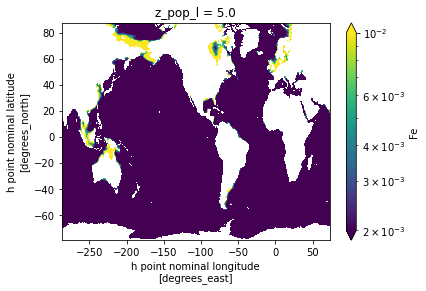

In [29]:
mom_hist_ds["Fe"].isel(z_pop_l=0).mean("time").plot(norm=colors.LogNorm(vmin=.002, vmax=.010))

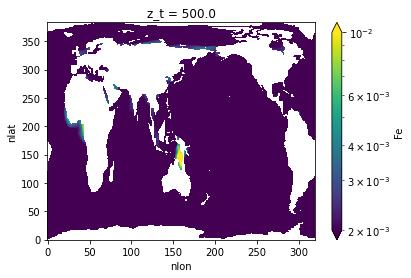

In [28]:
pop_hist_ds["Fe"].isel(z_t=0).mean("time").plot(norm=colors.LogNorm(vmin=.002, vmax=.010))

In [37]:
mom_weighted = mom_hist_ds["FESEDFLUX"].isel(time=0).sum(z_coord).weighted(mom_static_ds["area_t"]).sum(("xh", "yh")).compute().data
mom_weighted

array(1.13706465e+08)

<xarray.Dataset>
Dimensions:            (xh: 540, yh: 458, z_pop_l: 60, z_pop_i: 61, time: 12, nv: 2)
Coordinates:
  * xh                 (xh) float64 -286.7 -286.0 -285.3 ... 71.33 72.0 72.67
  * yh                 (yh) float64 -79.2 -79.08 -78.95 ... 87.64 87.71 87.74
  * z_pop_l            (z_pop_l) float64 5.0 15.0 25.0 ... 9.451e+05 9.454e+05
  * z_pop_i            (z_pop_i) float64 0.0 10.0 20.0 ... 9.453e+05 9.455e+05
  * time               (time) float64 6.95e+03 6.98e+03 ... 7.254e+03 7.284e+03
  * nv                 (nv) float64 1.0 2.0
Data variables: (12/108)
    BOT_FLUX_TO_TEND   (time, z_pop_l, yh, xh) float64 dask.array<chunksize=(1, 60, 458, 540), meta=np.ndarray>
    ALK                (time, z_pop_l, yh, xh) float64 dask.array<chunksize=(1, 60, 458, 540), meta=np.ndarray>
    DIC                (time, z_pop_l, yh, xh) float64 dask.array<chunksize=(1, 60, 458, 540), meta=np.ndarray>
    J_DIC              (time, z_pop_l, yh, xh) float64 dask.array<chunksize=(1, 60, 458, 540), meta=np.ndarray>
    DOC                (time, z_pop_l, yh, xh) float64 dask.array<chunksize=(1, 60, 458, 540), meta=np.ndarray>
    DOCr               (time, z_pop_l, yh, xh) float64 dask.array<chunksize=(1, 60, 458, 540), meta=np.ndarray>
    ...                 ...
    sp_agg             (time, z_pop_l, yh, xh) float64 dask.array<chunksize=(1, 60, 458, 540), meta=np.ndarray>
    h                  (time, z_pop_l, yh, xh) float64 dask.array<chunksize=(1, 60, 458, 540), meta=np.ndarray>
    average_T1         (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    average_T2         (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    average_DT         (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    time_bnds          (time, nv) float64 dask.array<chunksize=(1, 2), meta=np.ndarray>
Attributes:
    filename:          mom_oob.003.mom6.h_bgc_monthly_z_0020_01.nc
    title:             MOM6 diagnostic fields table for CESM case: mom_oob.003
    associated_files:  area_t: mom_oob.003.mom6.static.nc
    grid_type:         regular
    grid_tile:         N/A